In [1]:
import sys, os, glob, warnings, logging
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest
from sw_qPCR import *

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
# Read in data from different plates and combine them
plate_ids = ['220519-plate1', '220519-plate2', '220519-plate3']
dfs = []
for plate_id in plate_ids:
    dfs.append(get_plate_data(plate_id))

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)

# Add a few helpful columns
df['group'] = [df.Sample[i] + '___' + df.Primer[i] for i in range(len(df))]
df['well_id'] = [df.plate_id[i] + '-' + df.Well[i] for i in range(len(df))]
df['relExp_25'] = [2**(25-df.Cq[i]) for i in range(len(df))]

df.head()

,Well,Sample,Primer,Cq,plate_id,sgRNA_id,group,well_id,relExp_25
0,A01,A-188-1,Rps29 v1,19.334721,220519-plate1,188,A-188-1___Rps29 v1,220519-plate1-A01,50.747984
1,A02,A-188-2,Rps29 v1,19.577852,220519-plate1,188,A-188-2___Rps29 v1,220519-plate1-A02,42.877475
2,A03,A-188-3,Rps29 v1,19.335932,220519-plate1,188,A-188-3___Rps29 v1,220519-plate1-A03,50.705404
3,A04,A-188-4,Rps29 v1,19.627998,220519-plate1,188,A-188-4___Rps29 v1,220519-plate1-A04,41.412722
4,A05,A-188-5,Rps29 v1,20.491257,220519-plate1,188,A-188-5___Rps29 v1,220519-plate1-A05,22.764959


In [3]:
# # Insepct the amplification and melting curves of each plate per primer to check
# # if there are problematic data that should be excluded
# primers = ['Rps29 v1', 'Serpinh1 sg1 v2', 'Serpinh1 sg2 v1', 'Serpinh1 sg3 v1']
# for plate_id in plate_ids:
#     df_annotation = get_annotation_data(plate_id)
#     # for primer in df_annotation.Primer.unique():
#     for primer in primers:
#         plot_amplification_curves(plate_id, primer, ymax=None)
#         plot_melting_curves(plate_id, primer)

In [4]:
# Plots with abnormal curves:
### 220519-plate1_Rps29v1_melting_curves
### 220613-plate3_Rps29v1_amplification_curves
### 220613-plate4_Serpinh1sg1v2_melting_curves
### 220613-plate4_Serpinh1sg2v1_melting_curves

In [5]:
# plate_id = '220519-plate1'
# primer = 'Rps29 v1'
# df_annotation = get_annotation_data(plate_id)
# for sample in df_annotation.Sample.unique():
#     plot_melting_curves(plate_id, primer, sample=sample, save_fig=False)

In [6]:
# plate_id = '220613-plate3'
# primer = 'Rps29 v1'
# df_annotation = get_annotation_data(plate_id)
# for sample in df_annotation.Sample.unique():
#     plot_amplification_curves(plate_id, primer, sample=sample, save_fig=False)

In [7]:
# ### 220613-plate4_Serpinh1sg1v2_melting_curves

# plate_id = '220613-plate4'
# primer = 'Serpinh1 sg1 v2'
# df_annotation = get_annotation_data(plate_id)
# for sample in df_annotation.Sample.unique():
#     plot_melting_curves(plate_id, primer, sample=sample, save_fig=False)

In [8]:
# ### 220613-plate4_Serpinh1sg2v1_melting_curves

# plate_id = '220613-plate4'
# primer = 'Serpinh1 sg2 v1'
# df_annotation = get_annotation_data(plate_id)
# for sample in df_annotation.Sample.unique():
#     plot_melting_curves(plate_id, primer, sample=sample, save_fig=False)

In [9]:
# By inspecting the curves above, curate a list of samples to exclude
samples_to_exclude = ['H2O', 'a-228-2', 'b-229-6']

df = df[~df.Sample.isin(samples_to_exclude)]
df.reset_index(drop=True, inplace=True)

In [10]:
def remove_outliers(df, rel_std_threshold = 0.25):
    ''''''
    if 'group' not in df.columns:
        df['group'] = [df.Sample[i] + '___' + df.Primer[i] for i in range(len(df))]
    if 'well_id' not in df.columns:
        df['well_id'] = [df.plate_id[i] + '-' + df.Well[i] for i in range(len(df))]
    if 'relExp_25' not in df.columns:
        df['relExp_25'] = [2**(25-df.Cq[i]) for i in range(len(df))]
    
    df_grouped = df.groupby('group').describe()['relExp_25'].reset_index()[['group', 'count', 'mean', 'std']]
    df_grouped['rel_std'] = df_grouped['std'] / df_grouped['mean']
    
    # make empty lists
    groups_to_remove, wells_to_remove = [], []
    
    # Remove groups with only 1 replicate
    if df_grouped['count'].min()<2:
        groups_to_remove = groups_to_remove + df_grouped[df_grouped['count']<2]['group'].unique()
    
    # For groups with 3 or more wells of data, when the relative std is larger than threshold:    
    #     - Remove a single outlier well from the group, if that can lower relative std below threshold
    #     - Otherwise, remove the entire group
    for group in df_grouped[df_grouped['rel_std'] > rel_std_threshold]['group'].unique():
        df_temp = df[df['group']==group]
        if len(df_temp) < 3:
            groups_to_remove.append(group)
        else:
            relExps = df_temp['relExp_25'].tolist()
            well_ids = df_temp['well_id'].tolist()
            relStds = []
            for i in range(len(relExps)):
                relExps_copy = relExps.copy()
                del relExps_copy[i]
                relStds.append(np.std(relExps_copy) / np.mean(relExps_copy))
            if np.min(relStds) <= rel_std_threshold:
                wells_to_remove.append(well_ids[np.argmin(relStds)])
            else:
                groups_to_remove.append(group)
    
    df_filtered = df[~df['well_id'].isin(wells_to_remove)]
    df_filtered = df_filtered[~df_filtered['group'].isin(groups_to_remove)]
    df_filtered.reset_index(drop=True, inplace=True)
    
    return df_filtered

In [11]:
df = remove_outliers(df)

In [12]:
df.shape

(219, 9)

In [13]:
df.head()

,Well,Sample,Primer,Cq,plate_id,sgRNA_id,group,well_id,relExp_25
0,A01,A-188-1,Rps29 v1,19.334721,220519-plate1,188,A-188-1___Rps29 v1,220519-plate1-A01,50.747984
1,A02,A-188-2,Rps29 v1,19.577852,220519-plate1,188,A-188-2___Rps29 v1,220519-plate1-A02,42.877475
2,A03,A-188-3,Rps29 v1,19.335932,220519-plate1,188,A-188-3___Rps29 v1,220519-plate1-A03,50.705404
3,A04,A-188-4,Rps29 v1,19.627998,220519-plate1,188,A-188-4___Rps29 v1,220519-plate1-A04,41.412722
4,A05,A-188-5,Rps29 v1,20.491257,220519-plate1,188,A-188-5___Rps29 v1,220519-plate1-A05,22.764959


In [14]:
df1 = get_expression_data(df, 'Serpinh1 sg1 v2')

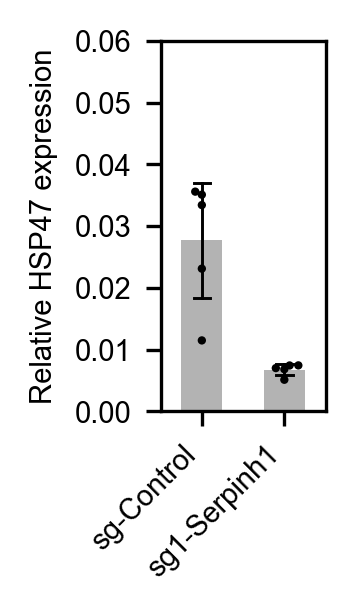

In [15]:
# Make plot for figure

fig_width, fig_height = 1.1, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Serpinh1-sg1-220519'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.45, 0.3, 0.5, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df1,
              x = 'sgRNA_id', y = 'relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df1,
            x = 'sgRNA_id', y = 'relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 0.06])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg1-Serpinh1']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel(r'Relative HSP47 expression')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [16]:
df2 = get_expression_data(df, 'Serpinh1 sg2 v1')

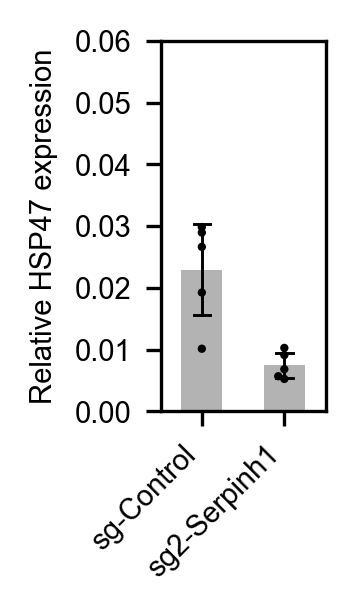

In [17]:
# Make plot for figure

fig_width, fig_height = 1.1, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Serpinh1-sg2-220519'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.45, 0.3, 0.5, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df2,
              x = 'sgRNA_id', y = 'relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df2,
            x = 'sgRNA_id', y = 'relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 0.06])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg2-Serpinh1']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel(r'Relative HSP47 expression')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [18]:
df3 = get_expression_data(df, 'Serpinh1 sg3 v1')

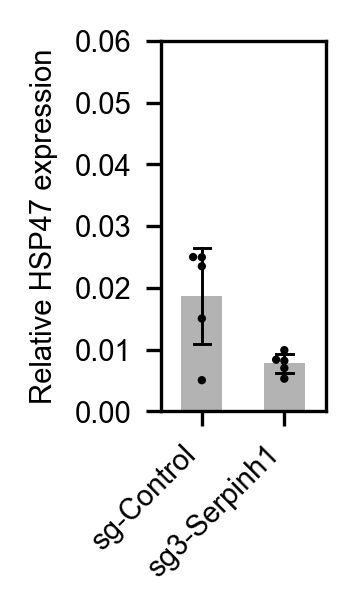

In [19]:
# Make plot for figure

fig_width, fig_height = 1.1, 1.9 # inches
line_width = .8
output_prefix = 'qPCR-Serpinh1-sg3-220519'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.45, 0.3, 0.5, 0.65])

# palette_dict = {'sg-Control': 'black', 'sg1-Itgb1': 'blue', 'sg2-Itgb1': 'red'}
# plotting_order = ['FGF7_NRG1_ITS', 'NRG1_ITS', 'FGF7_ITS', 'FGF7', 'medium_only']

sns.swarmplot(data = df3,
              x = 'sgRNA_id', y = 'relExp',
              size = 2,
              # hue = 'replicate_id',
              color = 'k',
              # order = plotting_order,
              # alpha = .5
             )
sns.barplot(data = df3,
            x = 'sgRNA_id', y = 'relExp',
            # order = plotting_order,
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

change_bar_width(ax, .5)

plt.ylim([0, 0.06])

# rotate and customize x tick labels if necessary
x_labels = ['sg-Control', 'sg3-Serpinh1']
# ax.set_xticklabels(labels=x_labels)
# x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel('')
plt.ylabel(r'Relative HSP47 expression')

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [20]:
tukeyTest(df1.relExp, df1.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   188    228   -0.021 0.002 -0.0317 -0.0102   True
---------------------------------------------------
p values of all pair-wise tests:
 [0.00203579]


In [21]:
tukeyTest(df2.relExp, df2.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   188    229  -0.0155 0.0037 -0.0244 -0.0067   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.00367999]


In [22]:
tukeyTest(df3.relExp, df3.sgRNA_id)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   188    230  -0.0109 0.0245 -0.0201 -0.0018   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.02448421]
